In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import (pad, to_tensor, normalize,
                                               hflip, vflip, rotate, crop)
from PIL import Image
import numpy as np
from skorch import NeuralNetRegressor
from skorch.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from skorch.callbacks import Checkpoint

import pandas as pd
import ast
import os
import random
import pdb

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def hflip_coordinates(start, end, image_width=256):
    """
    Apply horizontal flip to the coordinates of a line in an image.

    Parameters:
    - start: tuple, (x1, y1) coordinates of the line start point
    - end: tuple, (x2, y2) coordinates of the line end point
    - image_width: int, width of the image (default is 256)

    Returns:
    - new_start: tuple, new (x1, y1) coordinates after the horizontal flip
    - new_end: tuple, new (x2, y2) coordinates after the horizontal flip
    """
    new_x1 = image_width - 1 - start[0]
    new_y1 = start[1]
    new_x2 = image_width - 1 - end[0]
    new_y2 = end[1]

    new_start = (new_x1, new_y1)
    new_end = (new_x2, new_y2)

    return *new_start, *new_end


def vflip_coordinates(start, end, image_height=256):
    """
    Apply vertical flip to the coordinates of a line in an image and swap start and end points.

    Parameters:
    - start: tuple, (x1, y1) coordinates of the line start point
    - end: tuple, (x2, y2) coordinates of the line end point
    - image_height: int, height of the image (default is 256)

    Returns:
    - new_start: tuple, new (x1, y1) coordinates after the vertical flip
    - new_end: tuple, new (x2, y2) coordinates after the vertical flip
    """
    new_x1 = start[0]
    new_y1 = image_height - 1 - start[1]
    new_x2 = end[0]
    new_y2 = image_height - 1 - end[1]

    # Ensure coordinates are within the bounds of the image
    new_y2 = max(0, new_y2)

    # Swap the coordinates
    new_start = (new_x2, new_y2)
    new_end = (new_x1, new_y1)

    return *new_start, *new_end

In [11]:
# ResNet50 모델을 정의 (특징 추출기 부분만 사용)
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet50.children())[:-2])  # 마지막 두 층 제외
    
    def forward(self, x):
        return self.features(x)

    
# 특징 결합 및 회귀를 위한 모델 정의
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.feature_extractor1 = ResNet50FeatureExtractor()
        self.feature_extractor2 = ResNet50FeatureExtractor()
        self.fc = nn.Sequential(
            nn.Linear(2 * 2048 * 7 * 7, 512),  # 두 특징 맵을 결합한 후 FC 레이어에 전달
            nn.ReLU(),
            nn.Linear(512, 4)  # (x1, y1, x2, y2) 출력
        )
    
    def forward(self, x):
        image1, image2 = x
        features1 = self.feature_extractor1(image1)
        features2 = self.feature_extractor2(image2)
        combined_features = torch.cat((features1, features2), dim=1)  # 특징 결합
        combined_features = combined_features.view(combined_features.size(0), -1)  # FC 레이어에 전달하기 위해 펼치기
        output = self.fc(combined_features)
        return output
    
    
class ResNet18Regressor(nn.Module):
    def __init__(self):
        super(ResNet18Regressor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet18.children())[:-2])  # 마지막 두 층 제외
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  
        )
    
    def forward(self, x):
        #image1, image2 = x
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [21]:
# 이미지 전처리 함수 정의
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image



class ImagePairDataset(Dataset):
    def __init__(self, data_sample, random_flips=False):
        self.image_names = data_sample['Filename']
        self.targets = data_sample['Longest_Line']
        self.random_flips = random_flips

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join('crop_data', 'image', self.image_names[idx])
        mask_path = os.path.join('crop_data', 'mask', self.image_names[idx])
        image1 = preprocess_image(image_path)
        mask = preprocess_image(mask_path)
        pts = np.array(ast.literal_eval(self.targets[idx]), dtype=np.float32) 
        if self.random_flips:
            if random.random() < 0.5:
                #cell = hflip(cell)
                mask = hflip(mask)
                pts = [hflip_coordinates(pt[:2],pt[2:]) for pt in pts]

            if random.random() < 0.5:
                #cell = vflip(cell)
                mask = vflip(mask)
                pts = [vflip_coordinates(pt[:2],pt[2:]) for pt in pts]    
                
        pts = np.array([np.array(pt,dtype=np.float32)/255.0 for pt in pts], dtype=np.float32)
        #pdb.set_trace()
        #return (image1, image2), target #, self.image_names[idx]
        return mask, pts #, self.image_names[idx]

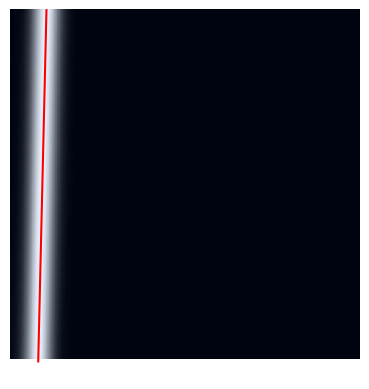

(torch.Size([3, 224, 224]),
 array([[0.10196079, 0.        , 0.07843138, 1.0039216 ]], dtype=float32))

In [22]:
model = ResNet18Regressor()
train_ds = ImagePairDataset(result_df, random_flips=True)
mask, target = train_ds[0]
lines = [vv * 224 for vv in target]  #target * 224.0  #
show_tensor_image(mask, lines)
mask.shape, target

In [23]:
# # 학습 및 검증 데이터셋으로 분할
# train_size = int(0.8 * len(train_ds))
# val_size = len(train_ds) - train_size
# train_ds, val_ds = random_split(train_ds, [train_size, val_size])

# # 데이터 로더 정의
# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, pin_memory=True)
# val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, pin_memory=True)

In [24]:
# Skorch를 사용하여 모델 정의 및 학습
net = NeuralNetRegressor(
    model, 
    max_epochs=500,
    lr=0.001,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,    
#     train_split=None,  # 내부 데이터 분할 비활성화
#     iterator_train=train_loader,
#     iterator_valid=val_loader,
    callbacks=[Checkpoint(f_params='best_params.pt')],    
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [25]:
# 데이터셋으로 모델 학습
net.fit(train_ds, y=None)

D:\2023\venv\nox39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128, 1, 4])) that is different to the input size (torch.Size([128, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\2023\venv\nox39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.1575        0.0933     +  5.1670
      2        0.0812        0.0838     +  4.7819
      3        0.0802        0.0792     +  4.9297
      4        0.0792        0.0759     +  4.9458
      5        0.0777        0.0731     +  5.0774
      6        0.0789        0.0729     +  5.0742
      7        0.0774        0.0724     +  5.0462
      8        0.0822        0.0805        4.8793
      9        0.0794        0.0717     +  4.8195
     10        0.0781        0.0781        5.0378
     11        0.0809        0.0725        4.9833
     12        0.0776        0.0714     +  4.9818
     13        0.0790        0.0741        5.1139
     14        0.0792        0.0922        4.8904
     15        0.0954        0.0787        4.8868
     16        0.0805        0.0750        5.0325
     17        0.0785        0.0714        4.6759
     18        0.0774        0.0742        4.6833


    158        0.0760        0.0713        4.9033
    159        0.0762        0.0702        4.9692
    160        0.0762        0.0708        4.8673
    161        0.0762        0.0736        4.8466
    162        0.0760        0.0708        4.8665
    163        0.0762        0.0704        4.8865
    164        0.0773        0.0740        4.9076
    165        0.0764        0.0730        4.9086
    166        0.0765        0.0702        4.8653
    167        0.0763        0.0709        4.8809
    168        0.0763        0.0710        4.8466
    169        0.0759        0.0709        4.8278
    170        0.0762        0.0705        4.9332
    171        0.0753        0.0720        4.9198
    172        0.0777        0.0720        4.8137
    173        0.0763        0.0702        4.8795
    174        0.0764        0.0720        4.8757
    175        0.0787        0.0753        4.8822
    176        0.0777        0.0713        4.8376
    177        0.0763        0.0704        4.8689


    322        0.0753        0.0712        4.9462
    323        0.0761        0.0741        4.9821
    324        0.0757        0.0711        5.0587
    325        0.0760        0.0706        4.9619
    326        0.0757        0.0726        5.0131
    327        0.0759        0.0705        4.9565
    328        0.0753        0.0706        4.9766
    329        0.0757        0.0744        4.9887
    330        0.0757        0.0704        5.0373
    331        0.0764        0.0705        4.9191
    332        0.0764        0.0748        4.9919
    333        0.0768        0.0704        4.9777
    334        0.0761        0.0703        5.0026
    335        0.0760        0.0702        4.9917
    336        0.0765        0.0718        5.0178
    337        0.0760        0.0699        5.0625
    338        0.0752        0.0700        5.0085
    339        0.0762        0.0718        4.9873
    340        0.0768        0.0714        5.0071
    341        0.0763        0.0703        4.9545


    486        0.0756        0.0692     +  5.0844
    487        0.0757        0.0726        5.1366
    488        0.0763        0.0696        5.0609
    489        0.0758        0.0709        4.9957
    490        0.0761        0.0707        4.9476
    491        0.0757        0.0724        5.0188
    492        0.0785        0.0743        5.0966
    493        0.0780        0.0711        5.0197
    494        0.0761        0.0734        5.0731
    495        0.0758        0.0747        5.0211
    496        0.0760        0.0703        4.9664
    497        0.0759        0.0721        5.0062
    498        0.0762        0.0713        5.0283
    499        0.0762        0.0726        5.0097
    500        0.0759        0.0719        4.9779


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ResNet18Regressor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [ ]:
aaa=net.predict(train_ds)

In [7]:
def show_tensor_image(tensor_image, lines=None):
    """
    Display a tensor image with optional lines.
    
    Parameters:
    - tensor_image: torch.Tensor, image tensor of shape (3, 256, 256)
    - lines: list of tuples, each containing start and end points of a line ((x1, y1), (x2, y2))
    """
    np_image = tensor_image.numpy()

    # Transpose the image to (256, 256, 3) from (3, 256, 256)
    np_image = np.transpose(np_image, (1, 2, 0))
    
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    plt.imshow(np_image)

    if lines is not None:
        for line in lines:
            start, end = line[:2],line[2:]
            x_values = [start[0], end[0]]
            y_values = [start[1], end[1]]
            plt.plot(x_values, y_values, 'r')  # 'r' is the color red
    
    plt.axis('off')  # Turn off axis
    plt.show()
    
    
def show_numpy_image(np_image, lines=None):
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    #plt.imshow(np_image, cmap='gray') 
    plt.imshow(np_image) 
    
    if lines is not None:
        for line in lines:
            start, end = line[:2],line[2:]
            x_values = [start[0], end[0]]
            y_values = [start[1], end[1]]
            plt.plot(x_values, y_values, 'r')  # 'r' is the color red
    
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
(image1, image2), target = train_ds[0]
#print(target*255, fname)
#lines = [int(x * 224) for x in target.squeeze()]
out = model((image1.cuda().unsqueeze(0), image2.cuda().unsqueeze(0)))
print(out, target)
show_tensor_image(image2, target*224)

In [ ]:
aaa.shape, len(train_ds)

In [ ]:
(image1, image2), target, fname = train_ds[0]
print(target*255, fname)
lines = [int(x * 255) for x in target]
show_tensor_image(image2, target*255)

In [2]:
# CSV 파일 읽기
csv_path = os.path.join('crop_data', 'pts_all.csv')
df = pd.read_csv(csv_path)

# 유클리드 거리 계산 함수
def euclidean_distance(points):
    x1, y1, x2, y2 = points
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# 가장 긴 직선만 남기기
def get_longest_line(points_str):
    points_list = ast.literal_eval(points_str)
    if len(points_list) <= 1:
        return points_str
    distances = [euclidean_distance(points) for points in points_list]
    max_distance_idx = np.argmax(distances)
    longest_line = points_list[max_distance_idx]
    return str([longest_line])

# 각 행에 대해 가장 긴 직선만 남기기
df['Longest_Line'] = df['Points'].apply(get_longest_line)

# 필요한 열만 선택
result_df = df[['Filename', 'Longest_Line']]

# 결과 확인
print(result_df[:3])
#len(result_df), result_df['Filename']

for fname in result_df['Filename']:
    print(fname)
    break

                             Filename          Longest_Line
0    frame_0089_part_1_time_41.53.jpg  [(229, 0, 235, 256)]
1  frame_0089_part_1_time_41.53_1.jpg    [(54, 0, 62, 256)]
2  frame_0089_part_1_time_41.53_2.jpg  [(238, 0, 244, 256)]
frame_0089_part_1_time_41.53.jpg
